Mini-Project 2: Performing a spectral analysis of a GRB 
 

In this project you will be performing a full spectral analysis of a GRB from start to finish, starting with a basic data product from the Fermi Gamma-Ray Burst Monitor (GBM) and finishing with the best fit spectral model parameters and their errors. This process will closely follow what is done by the Fermi team themselves. The process will have three major steps,

1. Calculate the background-subtracted counts in each of the 8 energy bins over the desired time interval
2. Setup the functions needed to calculate the expected counts in each energy bin for a spectral model (power-law spectra)
3. Find the best fit spectral model parameters and their errors using chi2 fitting 
 
You will be walked through the exact process below with several part to each major step. This process will string together skills and methods used in previous homeworks and tutorials. 

 

As usual, remember to comment your code where appropriate, include docstrings for any functions that you write, label all of your plot axes, and include a legend and labels on each plot that has more than one curve plotted. You may work on this assignment by yourself or with a partner. If you work with a partner, both partners should turn in a notebook and make sure to indicate at the top who they worked with. 

Part 1 - Setting up the data
Just as we did in tutorial 16, we will start some light curve data that has the observed counts in each time interval for 8 different energy bins. 

You can download the data from: [HERE](https://psu.instructure.com/courses/2367528/files/176346222/download?download_frd=1)

A. Using astropy's Table object read in the data. There are two tables in this FITS file that we want. The 3rd HDU (index 2) is the light curve data table and the 2nd HDU (index 1) is the measured energy bin table. The measured energy bins in this table correspond to the min and max measured energies for the 8 bins of counts in the light curve data table. 
- Read in both of these tables
- Print their column names
- Show the energy bin table (execute a cell containing just the table variable name or print it)

In [2]:
#import all required libraries
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import fits

from scipy import stats
from scipy.optimize import minimize

In [3]:
filename = 'glg_ctime_n3_bn240305409_v00.pha'
f = fits.open(filename)
f.info()

hdu1_table = Table.read(filename, hdu=1)
hdu2_table = Table.read(filename, hdu=2)

print(hdu1_table.colnames)
print(hdu2_table.colnames)

hdu1_table["E_MIN"]


Filename: glg_ctime_n3_bn240305409_v00.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   8R x 3C   [1I, 1E, 1E]   
  2  LIGHTCURVE    1 BinTableHDU     21   586R x 5C   [8I, E, I, D, D]   
['CHANNEL', 'E_MIN', 'E_MAX']
['COUNTS', 'EXPOSURE', 'QUALITY', 'TIME', 'ENDTIME']


4.233729
11.489111
26.632256
50.432938
102.38712
295.7403
539.2917
982.2319


 B. Plot the light curve as count rate (counts per second) summed over all 8 energy bins as a function of time. The time will be time since the "trigger time" (the time the spacecraft first detected the GRB). The trigger time is 731324966.26389 s

Make a new column in the table named 'dt', which will be TIME - trigger time
Calculate the total rates in each time bin by summing over the counts for each energy bin and dividing by the exposure time
Plot the total rates vs dt the function $plt.step()$ and set the x-axis limits to be -100 to 100

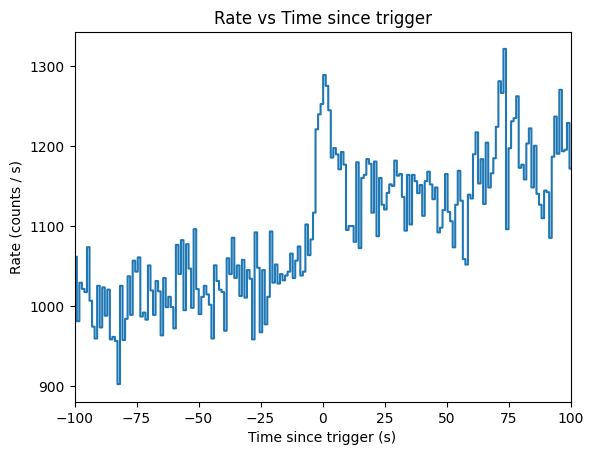

In [4]:
trigger_time = 731324966.26389
dt = hdu2_table["TIME"].data - trigger_time # Calculate time since trigger
hdu2_table['dt'] = dt # Add new col that is time since trigger


#print(hdu2_table['COUNTS'].shape)
counts1D = np.sum(hdu2_table['COUNTS'].data, axis=1) # Sum over all energy channels to get 1D counts
exposure = hdu2_table['EXPOSURE'].data # Get exposure times for each time bin
#print(counts1D.shape)

rate = counts1D / exposure # Calculate rate in counts/s

plt.step(dt, rate)
plt.xlim(-100,100)
plt.xlabel('Time since trigger (s)')
plt.ylabel('Rate (counts / s)')
plt.title('Rate vs Time since trigger')
plt.show()
#hdu2_table

You should see a sharp increase then drop off in rates from dt ~ -5 s to +15 s. This is the GRB. Around that interval the rates are not constant. There are several variable background sources, such as the Sun and the Earth's magnetic field changing as the spacecraft orbits around the Earth.

To approximate the changing background, typically a linear function is fit to the rates using data from before and after the GRB (to avoid including the GRB as part of the background estimation)

C. Fit a linear function to the total rates as a function of time using "background window" that is before and after the GRB with a gap in the middle to not include the GRB itself.

rates = slope*dt + y-intercept

* Create a boolean array that is True for the rows where dt between -100 s and -20 s, or +20 s and 100 s. 
* Get the total rates and the 1-sigma counting error on those rates where that boolean array is True
* Create a function that calculates the linear function (outputs the y-value, given the x-value, slope, and y-intercept)
* Find the best fit slope and y-intercept by minimizing the chi2 with respect to the slope and y-intercept

    *  $\chi^2 =  \sum_i^{N_{ebns}}\left(\frac{\left(data_i-f\left(x_i,m,b\right)\right)}{\sigma_i}\right)^2 $

        * where f is your linear function, data are your counts rates, and sigma is your 1-sigma counting error on those rates
    * You can use scipy's minimize function to numerically find the values for the slope and y-intercept that minimize the chi2, like you did in tutorial 18
    * For an initial guess, try using the mean of the count rate for the y-intercept and 0 for the slope. 
* Plot the total rates light curve again like you did in B., but this time also include your best-fit linear function plotted as a line. 
 

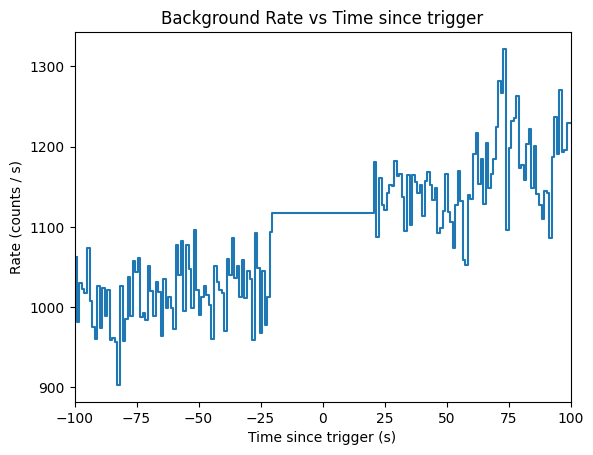

In [5]:
bkg_mask = ((np.abs(dt) >= 20) & (np.abs(dt) <= 100))  # Select rate values in the background time range
dt_bkg = dt[bkg_mask]  # Get the time values in the background time range
rate_bkg = rate[bkg_mask]  # Get the rate values in the background time range

#plot the background rate
plt.step(dt_bkg, rate_bkg)
plt.xlim(-100,100)
plt.xlabel('Time since trigger (s)')
plt.ylabel('Rate (counts / s)')
plt.title('Background Rate vs Time since trigger')
plt.show()

In [6]:
# Im comparing these two methods of calculating the sigmas
rate_bkg_sigmas = np.sqrt(rate_bkg * exposure[bkg_mask]) / exposure[bkg_mask]
    
#rate_bkg_sigmas2 = np.sqrt(counts1D[bkg_mask])/(exposure[bkg_mask])  # Calculate the rate uncertainties in counts/s
#print(rate_bkg_sigmas - rate_bkg_sigmas2)  # They are both the same, except for floating point errors

In [7]:
def linear_f(x, m, b):
    """
    Calculate the y-value of a linear function.

    Parameters:
    x (float or array-like): The independent variable(s).
    m (float): The slope of the line.
    b (float): The y-intercept of the line.
    
    Returns:
    float or array-like: The dependent variable(s) calculated as y = mx + b.
    """
    return m * x + b

#help(linear_f)

In [8]:
def calc_chi2(var, x, rate_bkg, rate_bkg_sigmas):
    """
    Calculate the chi-squared value for a given linear model.

    Parameters:
    var (list or tuple): A list or tuple containing the slope (m) and y-intercept (b) of the linear model.
    x (numpy.ndarray): The independent variable (e.g., time since trigger).
    rate_bkg (numpy.ndarray): The observed background rate values.
    rate_bkg_sigmas (numpy.ndarray): The sigma for the rate values.

    Returns:
    float: The chi-squared value calculated as:
           chi2 = sum(((observed_rate - expected_rate) / rate_uncertainty) ** 2)
    """
    m,b = var
    
    # Calculate the expected counts from the emission line
    expected_rate = linear_f(x,m,b)    
    # Calculate the chi2 value
    chi2 = np.sum((rate_bkg - expected_rate)**2 / rate_bkg_sigmas**2)

    return chi2

In [9]:
x = dt_bkg.copy()  # Independent variable (time since trigger)
#init_guess = [1.5, 1075]  # My initial guess for the slope (m) and y-intercept (b)
init_guess = [0, np.mean(rate)]

results = minimize(calc_chi2, x0=init_guess, args=(x, rate_bkg, rate_bkg_sigmas))
print(results)

min_chi2 = results.fun  # The minimum chi-squared value

best_m = results.x[0]
best_b = results.x[1]
print(f"\nThe best fit parameters are: slope (m) = {best_m}, y-intercept (b) = {best_b}\nThe minimum chi-squared value is: {min_chi2}")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 284.4257748724202
        x: [ 1.128e+00  1.087e+03]
      nit: 5
      jac: [-7.629e-06  3.815e-06]
 hess_inv: [[ 8.297e-04  3.339e-03]
            [ 3.339e-03  3.413e+00]]
     nfev: 18
     njev: 6

The best fit parameters are: slope (m) = 1.127561445686732, y-intercept (b) = 1086.9115561947676
The minimum chi-squared value is: 284.4257748724202


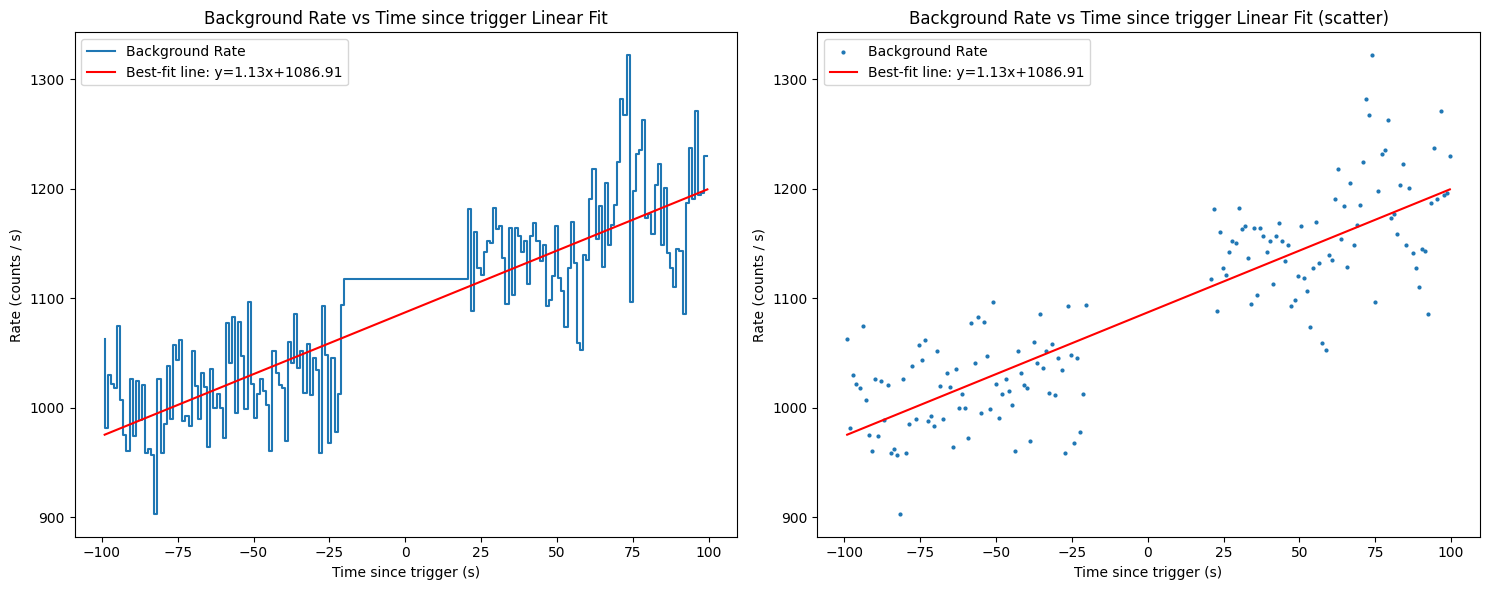

In [10]:
bkg_mask = ((np.abs(dt) >= 20) & (np.abs(dt) <= 100))  # Select rate values in the background time range
dt_bkg = dt[bkg_mask]  # Get the time values in the background time range
rate_bkg = rate[bkg_mask]  # Get the rate values in the background time range

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Create a 1-row, 2-column grid


axs[0].step(dt_bkg, rate_bkg, label='Background Rate')
# Plot the best-fit linear function
axs[0].plot(dt_bkg, linear_f(x, best_m, best_b), label=f'Best-fit line: y={best_m:.2f}x+{best_b:.2f}', color='red')
axs[0].set_xlabel('Time since trigger (s)')
axs[0].set_ylabel('Rate (counts / s)')
axs[0].set_title('Background Rate vs Time since trigger Linear Fit')
axs[0].legend()


#ploted the background rate again with the scatter plot because the step plot connecting the points before and after the GRB was a bit misleading
axs[1].scatter(dt_bkg, rate_bkg, label='Background Rate', s=4)
# Plot the best-fit linear function
axs[1].plot(dt_bkg, linear_f(dt_bkg, best_m, best_b), label=f'Best-fit line: y={best_m:.2f}x+{best_b:.2f}', color='red')
axs[1].set_xlabel('Time since trigger (s)')
axs[1].set_ylabel('Rate (counts / s)')
axs[1].set_title('Background Rate vs Time since trigger Linear Fit (scatter)')
axs[1].legend()


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

D. We want to find the background subtracted counts in each energy bin, so let's repeat C. but for each individual energy bin. 

* Instead of using the count rates summed over all 8 energy bins, use the count rate for a single energy bin. Do this for all 8 of them. 
    * Save the best fit slope and y-intercept values for each energy bin (in a list or array) 
* Include the min and max values (in keV) of the measured energy bin in the title of each plot. 

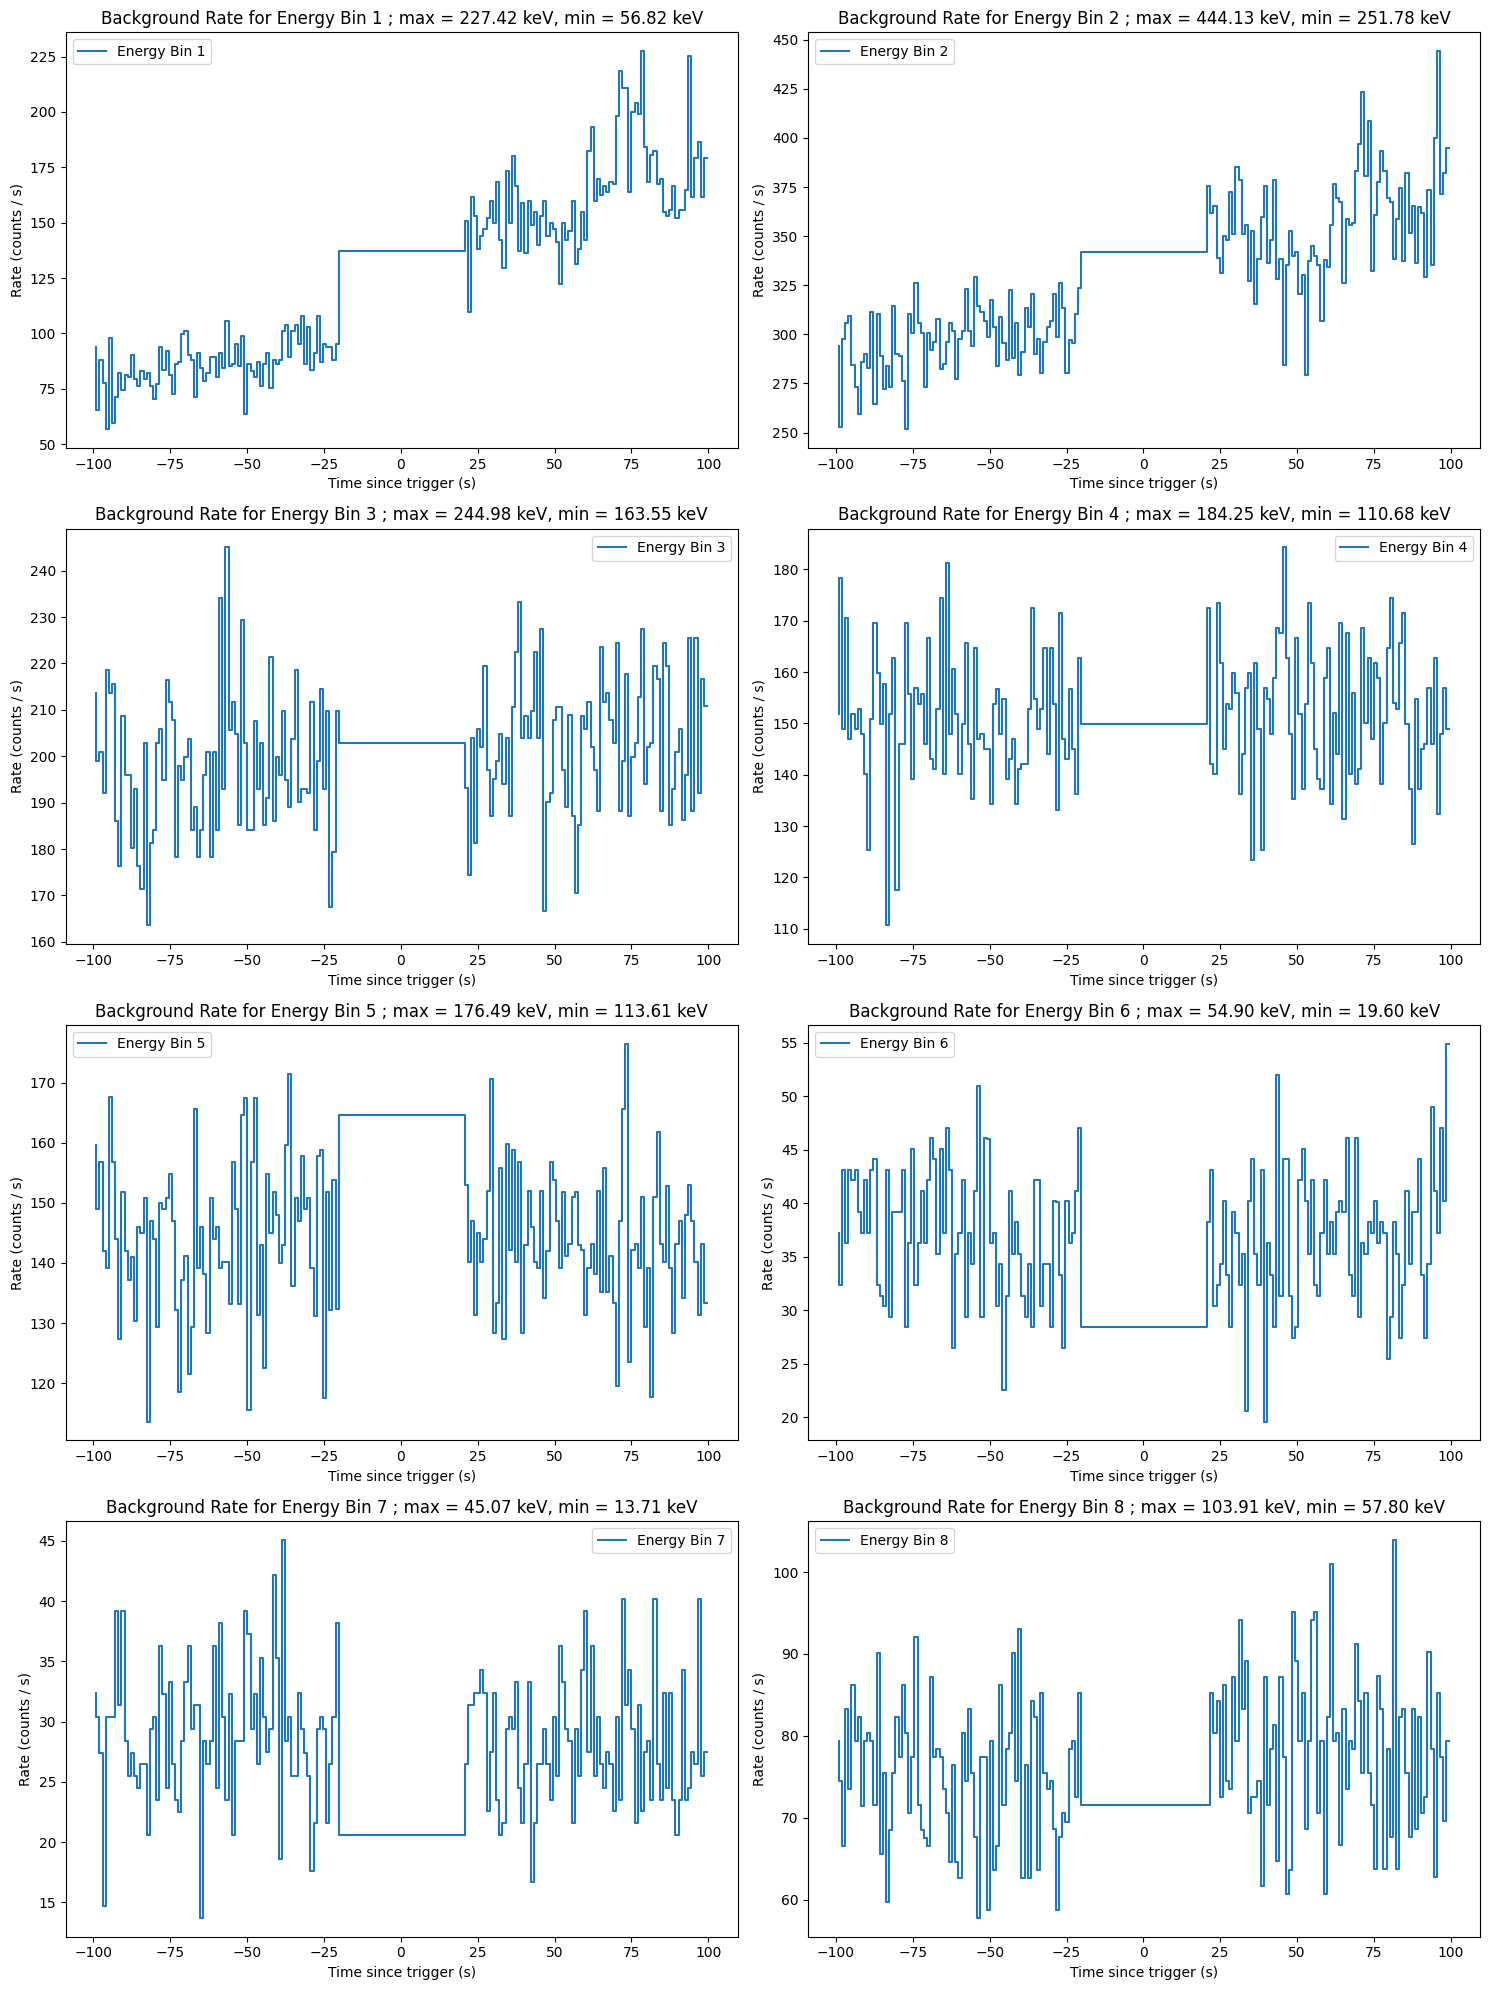

In [21]:
counts_arr = hdu2_table['COUNTS'].data  # Get the counts array from the table
# Reshape exposure to align with counts_arr for broadcasting
rates_arr = counts_arr / exposure[:, np.newaxis]  # Add a new axis to exposure
rates_bkg_arr = rates_arr[bkg_mask]  # Get the background rates

fig, axs = plt.subplots(4, 2, figsize=(15, 20))  # Create a 4x2 grid of subplots

for i in range(rates_arr.shape[1]):  # Loop through each energy bin
    ax = axs[i // 2, i % 2]  # Access the correct subplot in the 4x2 grid
    ax.step(dt_bkg, rates_bkg_arr[:, i], label=f'Energy Bin {i+1}')
    ax.set_xlabel('Time since trigger (s)')
    ax.set_ylabel('Rate (counts / s)')
    ax.set_title(f'Background Rate for Energy Bin {i+1} ; max = {np.max(rates_bkg_arr[:, i]):.2f} keV, min = {np.min(rates_bkg_arr[:, i]):.2f} keV')
    ax.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [13]:
best_fit_params = []  # List to store best-fit parameters for each energy bin

for i in range(rates_arr.shape[1]):  # Loop through each energy bin
    rate_i = rates_arr[:, i]  # Select the rate for the current energy bin
    rate_bkg_i = rates_bkg_arr[:, i]  # Select the background rate for the current energy bin
    rate_bkg_sigmas_i = np.sqrt(rate_bkg_i * exposure[bkg_mask]) / exposure[bkg_mask]  # Calculate uncertainties

    init_guess_i = [0, np.mean(rate_i)]  # Initial guess for slope and y-intercept

    # Perform minimization
    results = minimize(calc_chi2, x0=init_guess, args=(x, rate_bkg_i, rate_bkg_sigmas_i))# x = a copy of dt_bkg
    min_chi2 = results.fun  # Minimum chi-squared value
    best_m = results.x[0]  # Best-fit slope
    best_b = results.x[1]  # Best-fit y-intercept

    # Store the results
    best_fit_params.append((best_m, best_b))

    # Print the results for the current energy bin
    print(f"Energy Bin {i+1}:")
    print(f"  Best-fit slope (m) = {best_m}")
    print(f"  Best-fit y-intercept (b) = {best_b}")
    print(f"  Minimum chi-squared value = {min_chi2}\n")

Energy Bin 1:
  Best-fit slope (m) = 0.5835214212044848
  Best-fit y-intercept (b) = 122.4295418041297
  Minimum chi-squared value = 323.5558679439746

Energy Bin 2:
  Best-fit slope (m) = 0.4637796258714933
  Best-fit y-intercept (b) = 324.98478626393194
  Minimum chi-squared value = 221.28678318406003

Energy Bin 3:
  Best-fit slope (m) = 0.04981504420342739
  Best-fit y-intercept (b) = 199.16764820665466
  Minimum chi-squared value = 163.47257981327851

Energy Bin 4:
  Best-fit slope (m) = 0.009223375127125276
  Best-fit y-intercept (b) = 150.38817346473567
  Minimum chi-squared value = 171.76321071848042

Energy Bin 5:
  Best-fit slope (m) = -0.003907373379419094
  Best-fit y-intercept (b) = 143.0692989525081
  Minimum chi-squared value = 157.4406023305499

Energy Bin 6:
  Best-fit slope (m) = -0.006918833454606998
  Best-fit y-intercept (b) = 35.913026743369365
  Minimum chi-squared value = 174.89436012041756

Energy Bin 7:
  Best-fit slope (m) = -0.0038661998554905476
  Best-fit 

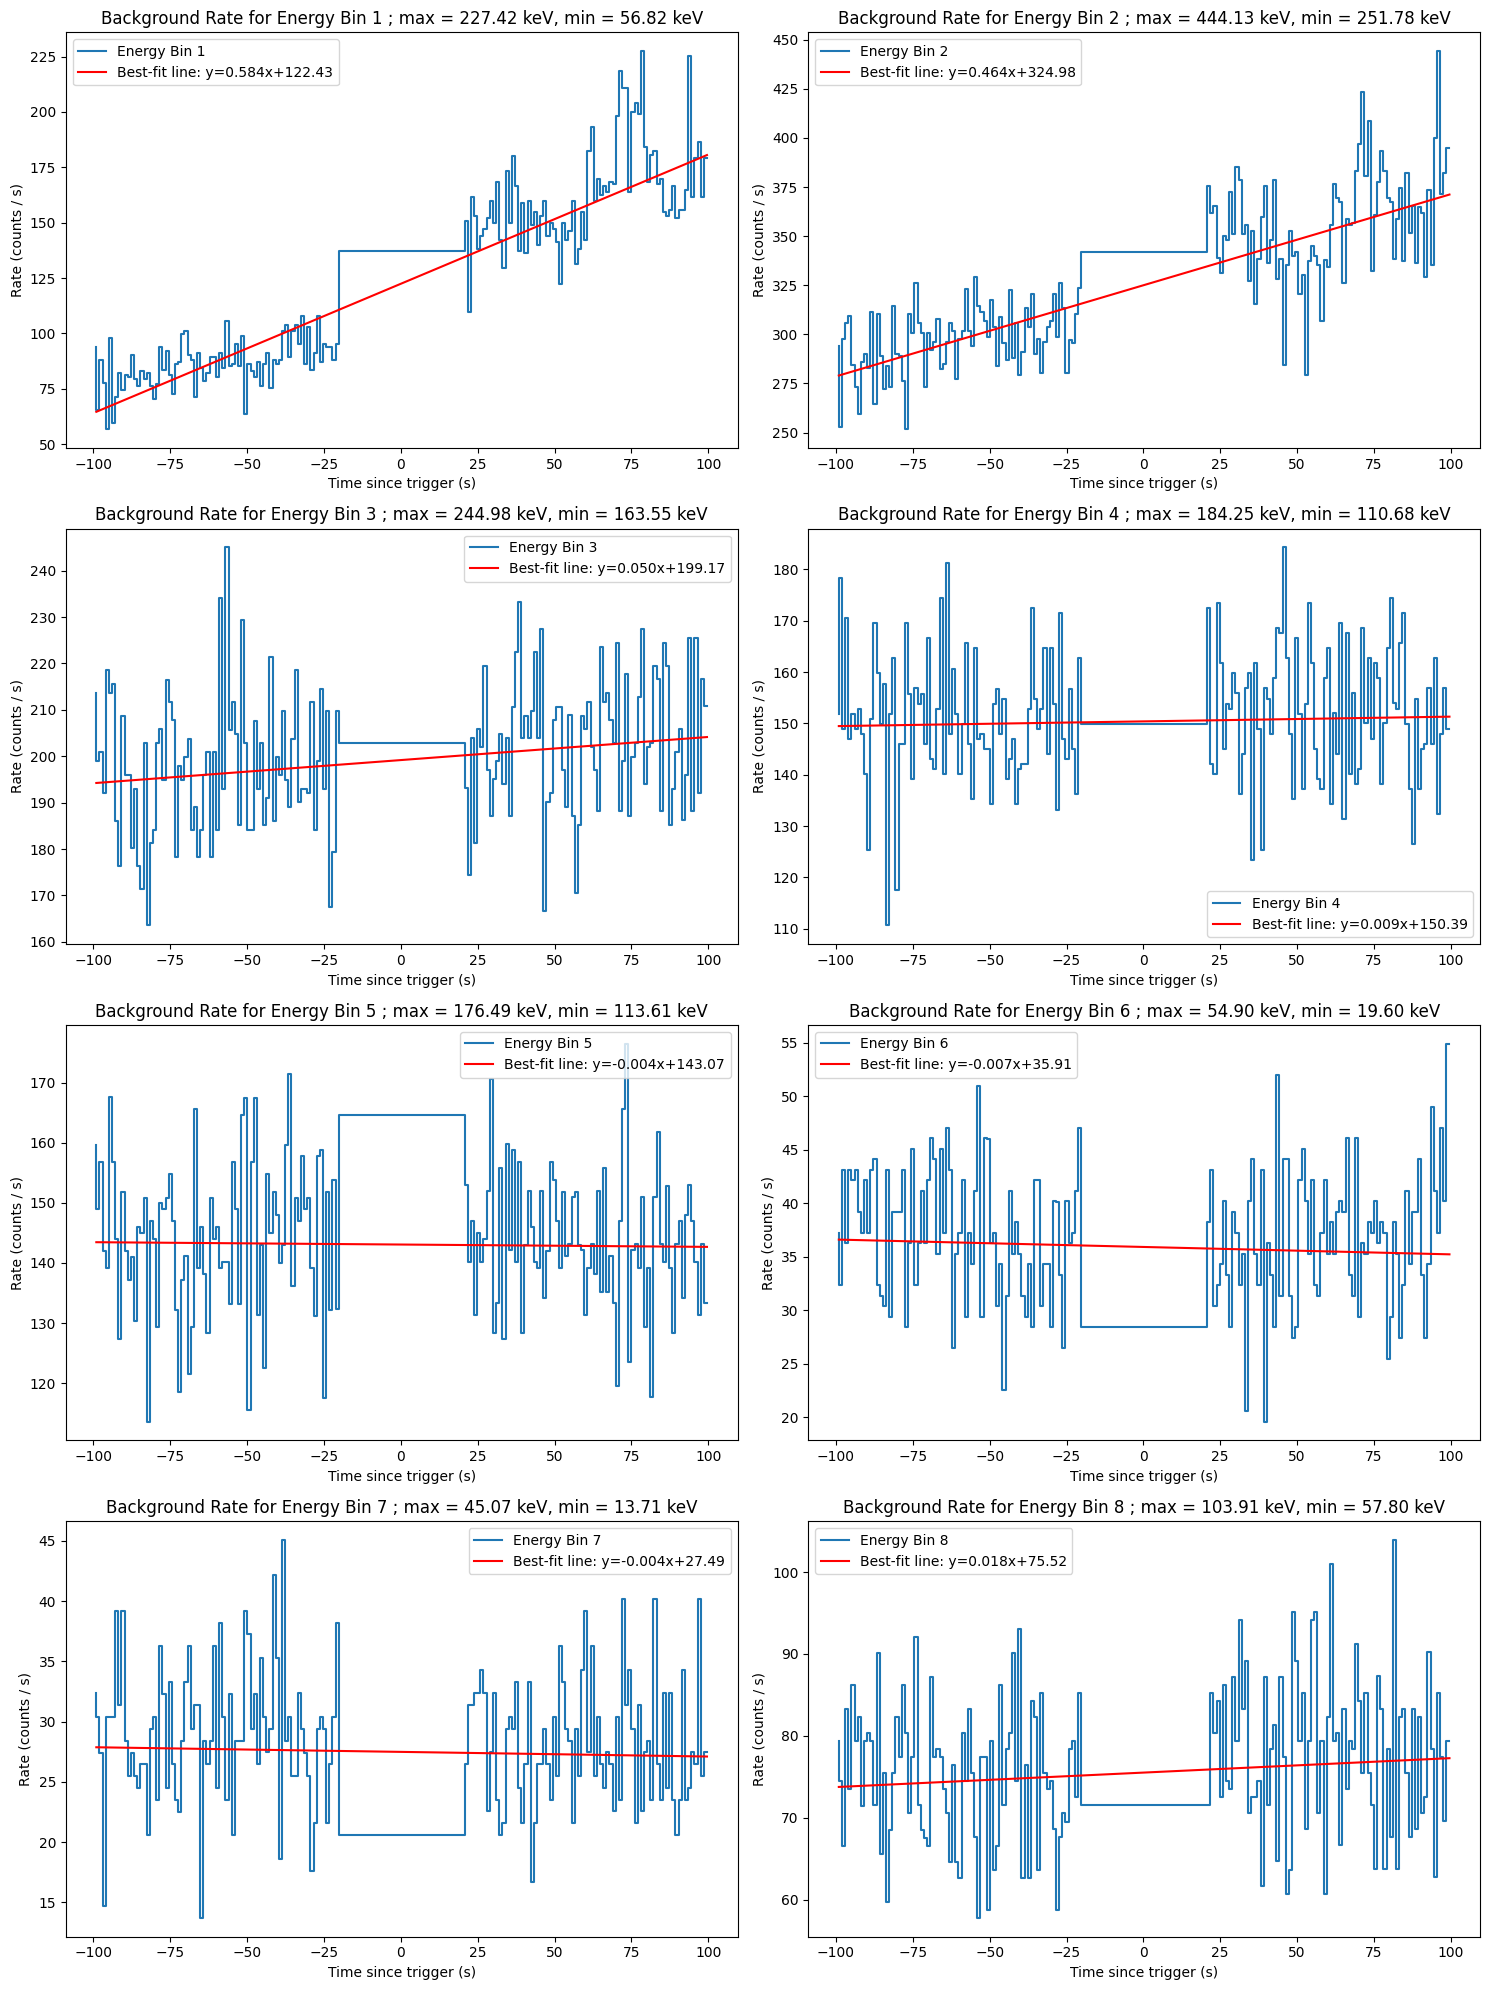

In [22]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))  # Create a 4x2 grid of subplots

for i in range(rates_arr.shape[1]):  # Loop through each energy bin
    best_m_i = best_fit_params[i][0]  # Best-fit slope for the current energy bin
    best_b_i = best_fit_params[i][1]  # Best-fit y-intercept for the current energy bin
    ax = axs[i // 2, i % 2]  # Access the correct subplot in the 4x2 grid
    ax.step(dt_bkg, rates_bkg_arr[:, i], label=f'Energy Bin {i+1}')
    # Plot the best-fit linear function
    ax.plot(dt_bkg, linear_f(x, best_m_i, best_b_i), label=f'Best-fit line: y={best_m_i:.3f}x+{best_b_i:.2f}', color='red')
    ax.set_xlabel('Time since trigger (s)')
    ax.set_ylabel('Rate (counts / s)')
    ax.set_title(f'Background Rate for Energy Bin {i+1} ; max = {np.max(rates_bkg_arr[:, i]):.2f} keV, min = {np.min(rates_bkg_arr[:, i]):.2f} keV')
    ax.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()